In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
import matplotlib.backends.backend_pdf

sns.set_theme(color_codes=True)
sys.path.insert(0, ".././0.data-download/scripts/")

from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras

import blitzgsea as blitz
import urllib.request

# Download the gene set library here: https://github.com/MaayanLab/blitzgsea


2023-06-27 11:31:56.177464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# list available gene set libraries in Enrichr
blitz.enrichr.print_libraries()

{'LIBRARY_LIST_URL': 'https://maayanlab.cloud/speedrichr/api/listlibs', 'LIBRARY_DOWNLOAD_URL': 'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=text&libraryName='}
0 - GeneSigDB
1 - Enrichr_Submissions_TF-Gene_Coocurrence
2 - SysMyo_Muscle_Gene_Sets
3 - WikiPathway_2021_Human
4 - HomoloGene
5 - WikiPathways_2013
6 - PFOCR_Pathways_2023
7 - OMIM_Disease
8 - Data_Acquisition_Method_Most_Popular_Genes
9 - Cancer_Cell_Line_Encyclopedia
10 - WikiPathways_2016
11 - WikiPathways_2015
12 - RNAseq_Automatic_GEO_Signatures_Human_Up
13 - Human_Gene_Atlas
14 - KOMP2_Mouse_Phenotypes_2022
15 - Kinase_Perturbations_from_GEO_down
16 - Disease_Signatures_from_GEO_down_2014
17 - Disease_Perturbations_from_GEO_up
18 - Old_CMAP_down
19 - MCF7_Perturbations_from_GEO_up
20 - NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions
21 - DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019
22 - PPI_Hub_Proteins
23 - Disease_Signatures_from_GEO_up_2014
24 - GTEx_Tissue_Expression_Up
25 - L1000_Kinase_and_GPCR_Perturbati

In [4]:
# use enrichr submodule to retrieve gene set library
# these libraries are finicky to work with--they usually work the first time but then may stop working. You may need to remove the library from your computer and trying to reimport it to work again.
library = blitz.enrichr.get_library("Reactome_2022")

In [5]:
# load the weight matrix 
gene_weight_dir = pathlib.Path("../2.train-VAE/results/weight_matrix_gsea.csv")
signature = pd.read_csv(gene_weight_dir)
print(signature.shape)
signature.head()

(2732, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,AAAS,-0.065762,-0.072253,0.047671,0.031671,0.099662,0.021346,0.065610,0.015976,0.035161,...,-0.042195,0.013708,-0.099784,-0.084774,-0.037435,0.040306,0.020068,0.052680,0.046233,-0.010818
1,AAMP,0.028984,-0.100351,0.015861,-0.041949,-0.070342,0.017694,-0.023452,0.054382,0.059402,...,0.026907,-0.022829,0.007821,0.028343,-0.053292,-0.011265,-0.035440,0.036614,-0.044030,-0.006800
2,AARS1,0.045330,-0.053818,0.010939,-0.000805,-0.039995,0.021862,0.076901,-0.063818,-0.064618,...,-0.019090,-0.054465,-0.036813,-0.022718,-0.070924,0.020863,0.021782,-0.044477,-0.013088,-0.012784
3,AARS2,-0.045774,0.007612,-0.011942,-0.046910,-0.053462,0.008274,-0.024193,-0.020667,-0.044887,...,0.073001,0.001621,0.030357,-0.032754,0.058778,-0.000040,0.089375,0.011618,0.060612,-0.019115
4,AASDHPPT,0.008627,-0.056030,-0.037565,0.022606,-0.011073,-0.043281,-0.008081,-0.025632,-0.042584,...,-0.079438,-0.066371,0.027453,0.034278,0.135766,0.023697,0.035598,-0.086139,0.094295,-0.030740


In [6]:
# Running GSEA

all_GSEA_results = []
all_signatures = []
results = []

range = signature.shape[1]

for col in signature.iloc[:,1:range].columns:
    df = signature.iloc[:,[0,int(col)]]
    result = blitz.gsea(df, library)
    results.append(result)
    all_GSEA_results.append(result.assign(z_dim=f"z_{col}"))
    all_signatures.append(df)

In [7]:
# Copying signature dataframe without gene column
neg_signature = signature.iloc[:, 1:].copy()

# Vertically shuffling the data in each column to create a negative control
for col in neg_signature.columns:
    neg_signature.loc[:, col] = np.random.permutation(neg_signature.loc[:, col].values)

# Adding gene column back to finalize negative control data
genes = signature.iloc[:,:1]
neg_signature.insert(0,'0', genes)

# Running GSEA with negative control data
neg_GSEA_results = []
negative_control = []

range = neg_signature.shape[1]

for col in neg_signature.iloc[:,1:range].columns:
    neg_df = neg_signature.iloc[:,[0,int(col)]]
    neg_result = blitz.gsea(neg_df, library)
    neg_GSEA_results.append(neg_result.assign(z_dim=f"z_{col}"))
    negative_control.append(neg_df)

In [8]:
# stack up all of the results to be analyzed
all_GSEA_results= pd.concat(all_GSEA_results)
neg_GSEA_results = pd.concat(neg_GSEA_results)

# merging real and negative control gsea results to single dataframe with column specifying source
all_GSEA_results['source'] = 'real'
neg_GSEA_results['source'] = 'negative control'

combo_gsea_df = pd.concat([all_GSEA_results, neg_GSEA_results])

# saving gsea results as single output file
combo_gsea_dir = pathlib.Path("./results/combined_gsea_results.csv.gz")
combo_gsea_df.to_csv(combo_gsea_dir, compression = 'gzip')


In [9]:
# sort by what you want to evaluate
combo_gsea_df.sort_values(by='nes', ascending = True)

,es,nes,pval,sidak,fdr,geneset_size,leading_edge,z_dim,source
Term,,,,,,,,,
Citric Acid (TCA) Cycle And Respiratory Electron Transport R-HSA-1428517,-0.591053,-6.091741,1.116891e-09,1.164917e-06,1.164917e-06,86,"ATP5PB,SDHA,ATP5PD,UQCRC2,NDUFAF3,NUBPL,NDUFAF...",z_19,real
"Respiratory Electron Transport, ATP Synthesis By Chemiosmotic Coupling, Heat Production By Uncoupling Proteins R-HSA-163200",-0.625882,-5.822677,5.791239e-09,6.040245e-06,3.020131e-06,71,"ATP5PB,ATP5PD,SDHA,UQCRC2,NDUFAF3,NUBPL,NDUFAF...",z_19,real
Citric Acid (TCA) Cycle And Respiratory Electron Transport R-HSA-1428517,-0.559939,-5.718526,1.074522e-08,1.120721e-05,1.120727e-05,86,"ATP5F1C,SUCLG1,NDUFB8,UQCRC1,UQCRFS1,LRPPRC,OG...",z_14,real
rRNA Processing In Nucleus And Cytosol R-HSA-8868773,-0.617078,-5.625068,1.854347e-08,1.934066e-05,1.934084e-05,63,"DIMT1,NOP2,EXOSC6,RPP21,NHP2,RIOK1,RPP38,EXOSC...",z_43,real
"Respiratory Electron Transport, ATP Synthesis By Chemiosmotic Coupling, Heat Production By Uncoupling Proteins R-HSA-163200",-0.595450,-5.551431,2.833404e-08,2.955197e-05,1.477620e-05,71,"ATP5F1C,NDUFB8,UQCRC1,LRPPRC,UQCRFS1,NDUFC1,ND...",z_14,real
...,...,...,...,...,...,...,...,...,...
Citric Acid (TCA) Cycle And Respiratory Electron Transport R-HSA-1428517,0.644308,6.964544,3.294630e-12,3.436299e-09,3.172358e-09,86,"NDUFS1,COX6C,NDUFV1,NDUFA6,NDUFS7,COX5B,SCO1,C...",z_46,real
Citric Acid (TCA) Cycle And Respiratory Electron Transport R-HSA-1428517,0.633752,6.993845,2.674633e-12,2.789642e-09,1.394821e-09,86,"NDUFB4,ATP5F1D,ATP5F1A,LRPPRC,COX20,NDUFA8,UQC...",z_30,real
"Respiratory Electron Transport, ATP Synthesis By Chemiosmotic Coupling, Heat Production By Uncoupling Proteins R-HSA-163200",0.682528,7.033377,2.015845e-12,2.102527e-09,1.394821e-09,71,"NDUFB4,ATP5F1D,ATP5F1A,LRPPRC,COX20,NDUFA8,UQC...",z_30,real


Text(0.5, 1.0, 'Control Gene Set Enrichment Analysis')

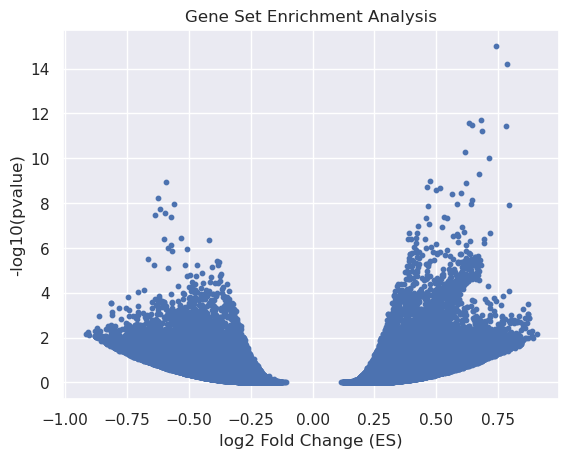

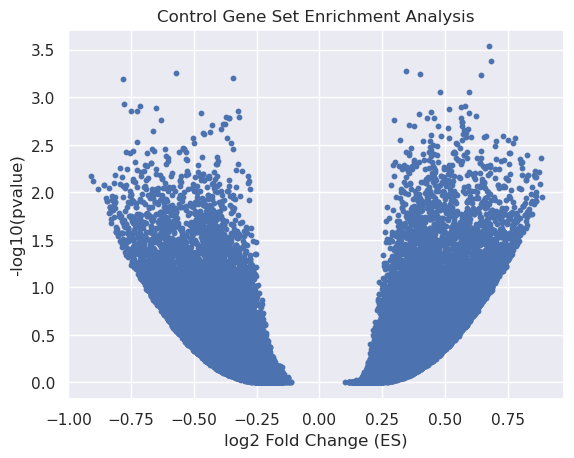

In [10]:
plt.figure()
plt.scatter(x=all_GSEA_results['es'],y=all_GSEA_results['pval'].apply(lambda x:-np.log10(x)),s=10)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(pvalue)')
plt.title('Gene Set Enrichment Analysis')

plt.figure()
plt.scatter(x=neg_GSEA_results['es'],y=neg_GSEA_results['pval'].apply(lambda x:-np.log10(x)), s=10)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(pvalue)')
plt.title('Control Gene Set Enrichment Analysis')

In [11]:
# Using VAE generated data

pdf_path = pathlib.Path("../1.data-exploration/figures/gsea_plots.pdf")
pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_path)

# Looping over each dataframe in all_signatures to generate gsea plots for the chosen geneset with data 
# from each latent dimension and saving the plots to a singular pdf
for df in all_signatures:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]

    geneset = "Signal Transduction R-HSA-162582"

    text, ax = plt.subplots()
    ax.text(0.5, 0.5, 'The three following figures visualize the gene set enrichment analysis results for ' + geneset + ' in the latent dimension z=' + dim, fontsize=16, ha='center')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    pdf.savefig(text, bbox_inches='tight')
    plt.close()

    fig = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=False)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()


    fig_compact = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=True)
    pdf.savefig(fig_compact, bbox_inches='tight')
    plt.close()

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    pdf.savefig(fig_table, bbox_inches='tight')
    plt.close()

pdf.close()


# Using negative control

ctrl_pdf_path = pathlib.Path("../1.data-exploration/figures/ctrl_gsea_plots.pdf")
ctrl_pdf = matplotlib.backends.backend_pdf.PdfPages(ctrl_pdf_path)

# Looping over each dataframe in negative_control to generate gsea plots for the chosen geneset with data 
# from each latent dimension and saving the plots to a singular pdf
for df in negative_control:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]

    geneset = "Signal Transduction R-HSA-162582"

    text, ax = plt.subplots()
    ax.text(0.5, 0.5, 'The three following figures visualize the negative control gene set enrichment analysis results for ' + geneset + ' in the latent dimension z=' + dim, fontsize=16, ha='center')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ctrl_pdf.savefig(text, bbox_inches='tight')
    plt.close()

    fig = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=False)
    ctrl_pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    fig_compact = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=True)
    ctrl_pdf.savefig(fig_compact, bbox_inches='tight')
    plt.close()

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    ctrl_pdf.savefig(fig_table, bbox_inches='tight')
    plt.close()

ctrl_pdf.close()